In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys() :
  print('User Uploaded file "{name}" with length {length} bytes'.format(name = fn, length= len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User Uploaded file "kaggle.json" with length 72 bytes


In [2]:
!kaggle datasets download -d wenewone/cub2002011

Dataset URL: https://www.kaggle.com/datasets/wenewone/cub2002011
License(s): CC0-1.0
100% 1.49G/1.49G [00:30<00:00, 51.8MB/s]
100% 1.49G/1.49G [00:30<00:00, 52.0MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/cub2002011.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Data preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [7]:
# Load CUB-200-2011 dataset
class CUBDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        # Load images and labels
        images_path = os.path.join(root_dir, 'CUB_200_2011', 'images')
        self.image_paths = []
        self.labels = []

        # Get class folders
        class_folders = sorted(os.listdir(images_path))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_folders)}

        for class_name in class_folders:
            class_path = os.path.join(images_path, class_name)
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                # Simple train/test split (80/20)
                split_idx = int(0.8 * len(images))
                if train:
                    selected_images = images[:split_idx]
                else:
                    selected_images = images[split_idx:]

                for img_name in selected_images:
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



In [8]:
# Create datasets
train_dataset = CUBDataset('/content', transform=data_transform, train=True)
test_dataset = CUBDataset('/content', transform=data_transform, train=False)

In [9]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.class_to_idx)}")

Train dataset size: 9416
Test dataset size: 2380
Number of classes: 200


In [11]:
# METODE 1: ResNet tanpa Transfer Learning
class ResNetFromScratch(nn.Module):
    def __init__(self, num_classes=200):
        super(ResNetFromScratch, self).__init__()
        # Using ResNet18 architecture
        self.resnet = models.resnet18(pretrained=False)
        # Modify the final fully connected layer for our number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [12]:
# METODE 2: ResNet dengan Feature Extraction (Pre-trained)
class ResNetFeatureExtraction(nn.Module):
    def __init__(self, num_classes=200):
        super(ResNetFeatureExtraction, self).__init__()
        # Using pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [13]:
# METODE 3: ResNet dengan Fine-Tuning
class ResNetFineTuning(nn.Module):
    def __init__(self, num_classes=200):
        super(ResNetFineTuning, self).__init__()
        # Using pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        # All parameters are trainable (fine-tuning)

    def forward(self, x):
        return self.resnet(x)

In [14]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, model_name="Model"):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    print(f"\n=== Training {model_name} ===")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Testing phase
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_accuracies

In [15]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [16]:
# Plotting function
def plot_results(results, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    for model_name, (train_losses, train_accs, test_accs) in results.items():
        ax1.plot(train_losses, label=f'{model_name} Loss')

    ax1.set_title(f'{title} - Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    for model_name, (train_losses, train_accs, test_accs) in results.items():
        ax2.plot(train_accs, label=f'{model_name} Train Acc')
        ax2.plot(test_accs, label=f'{model_name} Test Acc', linestyle='--')

    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [17]:
# Main execution
num_epochs = 10
num_classes = 200
results = {}

In [18]:
# 1. ResNet Tanpa Transfer Learning)
print("\n" + "="*50)
print("1. TRAINING RESNET TANPA TRANSFER LEARNING")
print("="*50)

model1 = ResNetFromScratch(num_classes).to(device)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

train_losses1, train_accs1, test_accs1 = train_model(
    model1, train_loader, test_loader, criterion1, optimizer1,
    num_epochs, "ResNet From Scratch"
)
results["From Scratch"] = (train_losses1, train_accs1, test_accs1)


1. TRAINING RESNET TANPA TRANSFER LEARNING


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



=== Training ResNet From Scratch ===
Epoch [1/10], Loss: 5.2576, Train Acc: 1.39%, Test Acc: 2.31%
Epoch [2/10], Loss: 4.7836, Train Acc: 2.84%, Test Acc: 4.54%
Epoch [3/10], Loss: 4.3913, Train Acc: 5.48%, Test Acc: 6.13%
Epoch [4/10], Loss: 4.0358, Train Acc: 8.76%, Test Acc: 8.82%
Epoch [5/10], Loss: 3.7129, Train Acc: 12.69%, Test Acc: 12.82%
Epoch [6/10], Loss: 3.4307, Train Acc: 17.37%, Test Acc: 15.34%
Epoch [7/10], Loss: 3.1341, Train Acc: 22.66%, Test Acc: 16.93%
Epoch [8/10], Loss: 2.8516, Train Acc: 28.42%, Test Acc: 24.16%
Epoch [9/10], Loss: 2.6145, Train Acc: 32.60%, Test Acc: 23.78%
Epoch [10/10], Loss: 2.3861, Train Acc: 37.80%, Test Acc: 26.89%


In [19]:
# 2. ResNet dengan Feature Extraction
print("\n" + "="*50)
print("2. TRAINING RESNET DENGAN FEATURE EXTRACTION")
print("="*50)

model2 = ResNetFeatureExtraction(num_classes).to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

train_losses2, train_accs2, test_accs2 = train_model(
    model2, train_loader, test_loader, criterion2, optimizer2,
    num_epochs, "Feature Extraction"
)
results["Feature Extraction"] = (train_losses2, train_accs2, test_accs2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



2. TRAINING RESNET DENGAN FEATURE EXTRACTION
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 235MB/s]



=== Training Feature Extraction ===
Epoch [1/10], Loss: 3.9665, Train Acc: 19.14%, Test Acc: 35.76%
Epoch [2/10], Loss: 2.2405, Train Acc: 50.59%, Test Acc: 48.19%
Epoch [3/10], Loss: 1.6523, Train Acc: 62.91%, Test Acc: 51.85%
Epoch [4/10], Loss: 1.3407, Train Acc: 69.25%, Test Acc: 52.56%
Epoch [5/10], Loss: 1.1454, Train Acc: 73.23%, Test Acc: 53.24%
Epoch [6/10], Loss: 1.0137, Train Acc: 76.12%, Test Acc: 54.24%
Epoch [7/10], Loss: 0.8922, Train Acc: 79.08%, Test Acc: 54.75%
Epoch [8/10], Loss: 0.8097, Train Acc: 81.01%, Test Acc: 54.79%
Epoch [9/10], Loss: 0.7319, Train Acc: 82.87%, Test Acc: 55.88%
Epoch [10/10], Loss: 0.6750, Train Acc: 84.27%, Test Acc: 55.13%


In [20]:
# 3. ResNet dengan Fine-Tuning
print("\n" + "="*50)
print("3. TRAINING RESNET DENGAN FINE-TUNING")
print("="*50)

model3 = ResNetFineTuning(num_classes).to(device)
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001, weight_decay=1e-4)

train_losses3, train_accs3, test_accs3 = train_model(
    model3, train_loader, test_loader, criterion3, optimizer3,
    num_epochs, "Fine-Tuning"
)
results["Fine-Tuning"] = (train_losses3, train_accs3, test_accs3)


3. TRAINING RESNET DENGAN FINE-TUNING

=== Training Fine-Tuning ===
Epoch [1/10], Loss: 3.8937, Train Acc: 25.78%, Test Acc: 45.67%
Epoch [2/10], Loss: 1.9652, Train Acc: 66.73%, Test Acc: 63.11%
Epoch [3/10], Loss: 1.0002, Train Acc: 85.15%, Test Acc: 69.08%
Epoch [4/10], Loss: 0.4573, Train Acc: 95.69%, Test Acc: 70.34%
Epoch [5/10], Loss: 0.1775, Train Acc: 99.37%, Test Acc: 71.34%
Epoch [6/10], Loss: 0.0760, Train Acc: 99.98%, Test Acc: 72.94%
Epoch [7/10], Loss: 0.0408, Train Acc: 99.98%, Test Acc: 72.98%
Epoch [8/10], Loss: 0.0271, Train Acc: 99.98%, Test Acc: 72.77%
Epoch [9/10], Loss: 0.0199, Train Acc: 99.99%, Test Acc: 73.24%
Epoch [10/10], Loss: 0.0181, Train Acc: 99.98%, Test Acc: 72.61%


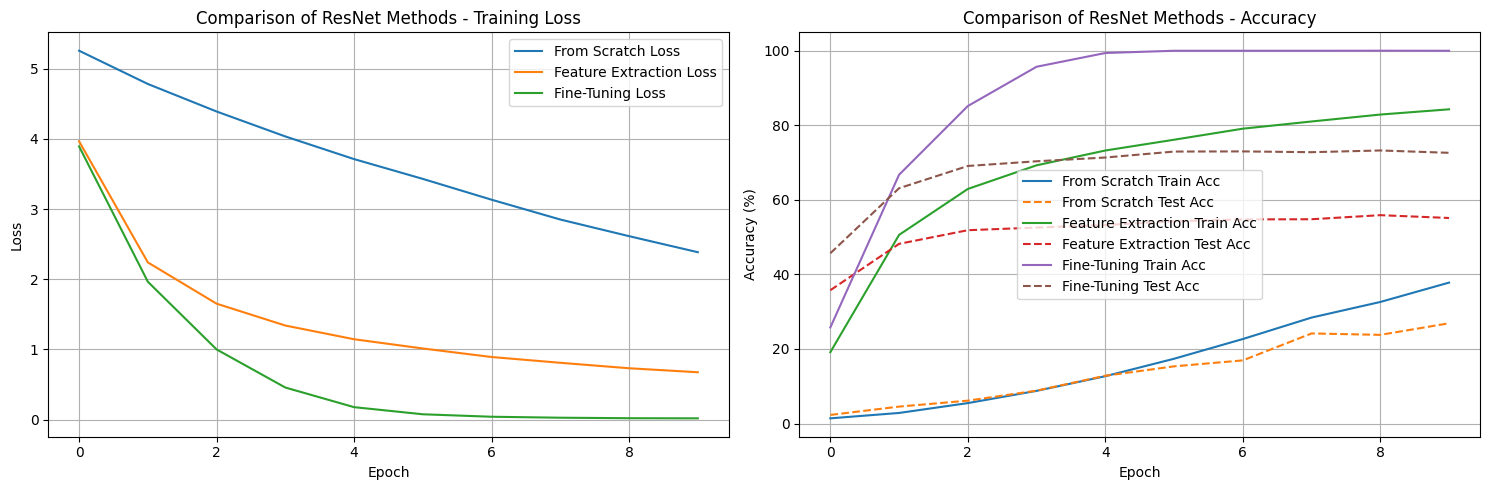

In [21]:
# Plot results
plot_results(results, "Comparison of ResNet Methods")

In [22]:
# Final evaluation
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

final_results = {}
for model_name, model in [("From Scratch", model1),
                         ("Feature Extraction", model2),
                         ("Fine-Tuning", model3)]:
    accuracy = evaluate_model(model, test_loader)
    final_results[model_name] = accuracy
    print(f"{model_name}: {accuracy:.2f}%")


FINAL EVALUATION
From Scratch: 26.89%
Feature Extraction: 55.13%
Fine-Tuning: 72.61%


In [23]:
# Create comparison table
print("\n" + "="*50)
print("COMPARISON SUMMARY")
print("="*50)
comparison_df = pd.DataFrame(list(final_results.items()),
                           columns=['Method', 'Test Accuracy (%)'])
print(comparison_df)


COMPARISON SUMMARY
               Method  Test Accuracy (%)
0        From Scratch          26.890756
1  Feature Extraction          55.126050
2         Fine-Tuning          72.605042


In [24]:
print("\n" + "="*50)
print("ANALYSIS")
print("="*50)
best_method = max(final_results, key=final_results.get)
print(f"Best performing method: {best_method} ({final_results[best_method]:.2f}%)")


ANALYSIS
Best performing method: Fine-Tuning (72.61%)
